# Real-world use case
## Retention offer

In [1]:
import json
import numpy as np
import pandas as pd
import warnings
import shap
import lime.lime_tabular
import sys
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split
import os

warnings.filterwarnings("ignore")
np.random.seed(seed=1)

In [2]:
# path here
path = os.getcwd().replace('evaluation','')
sys.path.append(path)

In [3]:
from smace.rules import Rule
from smace.decisions import DM
from smace.explainer import Smace
from smace.models import Model
from smace import utils

In [4]:
# input data
df = pd.read_csv('telco_data.csv').drop(columns={'ID'})

In [5]:
df.head()

,CHURN,Gender,Status,Children,Est Income,Car Owner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan,LTV
0,T,F,S,1,38000.00,N,24.393333,23.56,0.0,206.08,0,CC,Budget,Intnl_discount,229.64,3,2739.24
1,F,M,M,2,29616.00,N,49.426667,29.78,0.0,45.50,0,CH,FreeLocal,Standard,75.29,2,740.08
2,F,M,M,0,19732.80,N,50.673333,24.81,0.0,22.44,0,CC,FreeLocal,Standard,47.25,3,527.79
3,F,M,S,2,96.33,N,56.473333,26.13,0.0,32.88,1,CC,Budget,Standard,59.01,1,613.85
4,F,F,M,2,52004.80,N,25.140000,5.03,0.0,23.11,0,CH,Budget,Intnl_discount,28.14,1,602.80


In [6]:
# decision rules
with open('telco_rules.json', 'r') as fp:
    rules_json = json.load(fp)

In [7]:
# preprocess
categorical_names = ['Gender', 'Status', 'Car Owner', 'Paymethod', 'LocalBilltype', 'LongDistanceBilltype']

def df_prep(dataframe):
    # String to numbers: {F,M} -> {0,1}
    for feature in categorical_names:
        le = sklearn.preprocessing.LabelEncoder()
        le.fit(dataframe[feature].astype(str))
        dataframe[feature] = le.transform(dataframe[feature].astype(str))
    return dataframe

In [8]:
# training data
y_cr = df.CHURN
y_ltv = df.LTV

data = df_prep(df.drop(columns={'CHURN', 'LTV'}))
data.head()

,Gender,Status,Children,Est Income,Car Owner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan
0,0,2,1,38000.00,0,24.393333,23.56,0.0,206.08,0,1,0,0,229.64,3
1,1,1,2,29616.00,0,49.426667,29.78,0.0,45.50,0,2,1,1,75.29,2
2,1,1,0,19732.80,0,50.673333,24.81,0.0,22.44,0,1,1,1,47.25,3
3,1,2,2,96.33,0,56.473333,26.13,0.0,32.88,1,1,0,1,59.01,1
4,0,1,2,52004.80,0,25.140000,5.03,0.0,23.11,0,2,0,0,28.14,1


In [9]:
# preprocess       
X = data.copy()
for feature in categorical_names:
    # ONE HOT ENCODING
    # Adding the new columns
    X = pd.concat([X, pd.get_dummies(X[feature], prefix=feature)], axis=1)
    # Removing the old nominal variables
    X.drop([feature], axis=1, inplace=True)
X = X.values

In [10]:
# models
xgb_cr = xgb.XGBClassifier(objective='reg:logistic').fit(X, y_cr)
xgb_ltv = xgb.XGBRegressor().fit(X, y_ltv)

In [11]:
# preprocess for example  
def preprocess(x):
    X = data.copy()
    if x.ndim == 1:
        x = np.expand_dims(list(x), axis=0)
    x = pd.DataFrame(x, columns=list(X.columns))
    x = df_prep(x)
    X = X.append(x)
    for feature in categorical_names:
        # ONE HOT ENCODING
        # Adding the new columns
        X = pd.concat([X, pd.get_dummies(X[feature], prefix=feature)], axis=1)
        # Removing the old nominal variables
        X.drop([feature], axis=1, inplace=True)
    return X.tail(x.shape[0]).values.astype(np.float)

In [12]:
cr_mod = Model(xgb_cr, 'cr', data, mode='classification', preprocess=preprocess)
ltv_mod = Model(xgb_ltv, 'ltv', data, mode='regression', preprocess=preprocess)

models_list = [cr_mod, ltv_mod]

In [13]:
# decision system
dm = DM(rules_json, models_list, data)

In [14]:
dm.rules['simple'].labels

['Age <= 50', 'ltv >= 500', 'cr >= 0.5', 'Usage >= 200', 'Local > 200']

In [15]:
example = data.loc[1]
print(example)

Gender                      1.000000
Status                      1.000000
Children                    2.000000
Est Income              29616.000000
Car Owner                   0.000000
Age                        49.426667
LongDistance               29.780000
International               0.000000
Local                      45.500000
Dropped                     0.000000
Paymethod                   2.000000
LocalBilltype               1.000000
LongDistanceBilltype        1.000000
Usage                      75.290000
RatePlan                    2.000000
Name: 1, dtype: float64


In [16]:
print('cr_mod predicts: ', str(cr_mod.predict(example)))
print('ltv_mod predicts: ', str(ltv_mod.predict(example)))
print('Not all conditions are met.')

cr_mod predicts:  [0.05124499]
ltv_mod predicts:  [766.62006]
Not all conditions are met.


Not all conditions are met.

We apply SMACE.

In [17]:
# Initialize the explainers
explainer = Smace(dm)
explanation = explainer.explain(example, 'simple')

In [18]:
explanation.model_table('cr')

,Contribution
Children,-0.279174
Status,-0.260145
LongDistance,0.092239
RatePlan,-0.076773
Est Income,-0.071027


In [19]:
explanation.model_table('ltv')

,Contribution
Age,-0.696085
Usage,-0.295786
Est Income,-0.008129
Gender,0.000000
Status,0.000000


In [20]:
explanation.rule_table(7)

,Contribution
Age,0.991
ltv,0.980
Usage,-0.655
cr,-0.551
Local,-0.534
Car Owner,0.000
LongDistance,0.000


<AxesSubplot:>

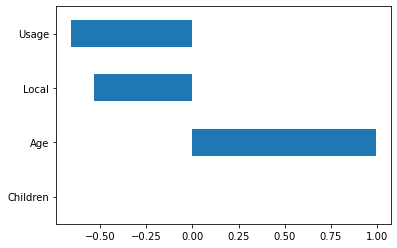

In [21]:
explanation.rule_bar(4)

<AxesSubplot:>

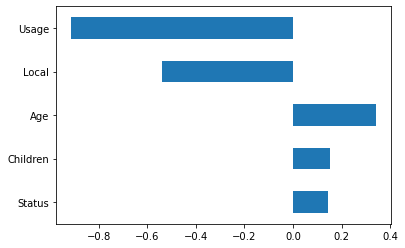

In [22]:
explanation.bar(8)

In [23]:
explanation.table(8)

,Example,Contribution
Usage,75.290000,-0.913175
Local,45.500000,-0.537582
Age,49.426667,0.339637
Children,2.000000,0.153825
Status,1.000000,0.143340
LongDistance,29.780000,-0.050824
RatePlan,2.000000,0.042302
Est Income,29616.000000,0.031169


<AxesSubplot:>

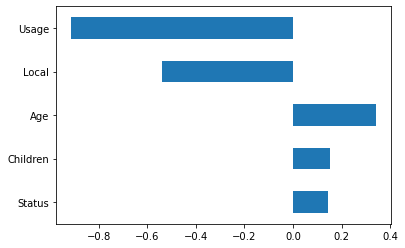

In [24]:
explanation.bar()